## Objective
The rising potential of this comparatively under-the-radar market fuels the need for an ML-based solution to develop a dynamic pricing strategy for used and refurbished devices. ReCell, a startup aiming to tap the potential in this market, has hired you as a data scientist. 

They want you to **analyze** the data provided and **build a linear regression model** to predict the price of a used phone/tablet and **identify factors** that significantly influence it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
df = pd.read_csv("used_device_data.csv")
df.head()

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [3]:
df['release_year'].unique()

array([2020, 2019, 2013, 2014, 2016, 2018, 2015, 2017], dtype=int64)

In [4]:
df['device_age'] = 2021 - df['release_year']
df['device_age']

0       1
1       1
2       1
3       1
4       1
       ..
3449    2
3450    3
3451    1
3452    1
3453    1
Name: device_age, Length: 3454, dtype: int64

In [5]:
df

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price,device_age
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100,1
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018,1
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631,1
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961,1
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,Asus,Android,15.34,yes,no,NaN,8.0,64.0,6.0,5000.0,190.0,2019,232,4.492337,6.483872,2
3450,Asus,Android,15.24,yes,no,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538,3
3451,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829,1
3452,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188,1


# Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand_name             3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   main_camera_mp         3275 non-null   float64
 6   selfie_camera_mp       3452 non-null   float64
 7   int_memory             3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
 15  devi

In [7]:
df.isnull().sum()

brand_name                 0
os                         0
screen_size                0
4g                         0
5g                         0
main_camera_mp           179
selfie_camera_mp           2
int_memory                 4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
device_age                 0
dtype: int64

In [8]:
a = df[df['battery'].isnull() == True]

a['os'].unique()

array(['Android', 'Windows', 'Others'], dtype=object)

In [9]:
# Filling Missing Values
# Different OS types might have significantly different camera capabilities etc. I'll be filling the Nan values based on their OS mean

os_main_camera_mean = df.groupby('os')['main_camera_mp'].mean().round(2)
df['main_camera_mp'] = df['main_camera_mp'].fillna(df['os'].map(os_main_camera_mean))


os_selfie_camera_mean = df.groupby('os')['selfie_camera_mp'].mean().round(2)
df['selfie_camera_mp'] = df['selfie_camera_mp'].fillna(df['os'].map(os_selfie_camera_mean))


os_int_memory_mean = df.groupby('os')['int_memory'].mean().round(2)
df['int_memory'] = df['int_memory'].fillna(df['os'].map(os_int_memory_mean))


os_ram_mean = df.groupby('os')['ram'].mean().round(2)
df['ram'] = df['ram'].fillna(df['os'].map(os_ram_mean))


os_battery_mean = df.groupby('os')['battery'].mean().round(2)
df['battery'] = df['battery'].fillna(df['os'].map(os_battery_mean))


os_weight_mean = df.groupby('os')['weight'].mean().round(2)
df['weight'] = df['weight'].fillna(df['os'].map(os_weight_mean))

In [10]:
df.isnull().sum()

brand_name               0
os                       0
screen_size              0
4g                       0
5g                       0
main_camera_mp           0
selfie_camera_mp         0
int_memory               0
ram                      0
battery                  0
weight                   0
release_year             0
days_used                0
normalized_used_price    0
normalized_new_price     0
device_age               0
dtype: int64

In [11]:
df[df.duplicated()]

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price,device_age


# Descriptive Analysis

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
screen_size,3454.0,13.713115,3.805280,5.080000,12.700000,12.830000,15.340000,30.710000
main_camera_mp,3454.0,9.476262,4.689489,0.080000,5.000000,9.770000,13.000000,48.000000
selfie_camera_mp,3454.0,6.554424,6.968358,0.000000,2.000000,5.000000,8.000000,32.000000
int_memory,3454.0,54.581503,84.923499,0.010000,16.000000,32.000000,64.000000,1024.000000
ram,3454.0,4.033602,1.366320,0.020000,4.000000,4.000000,4.000000,12.000000
battery,3454.0,3132.372646,1299.091271,500.000000,2100.000000,3000.000000,4000.000000,9720.000000
weight,3454.0,182.747782,88.324365,69.000000,142.000000,160.000000,185.000000,855.000000
release_year,3454.0,2015.965258,2.298455,2013.000000,2014.000000,2015.500000,2018.000000,2020.000000
days_used,3454.0,674.869716,248.580166,91.000000,533.500000,690.500000,868.750000,1094.000000
normalized_used_price,3454.0,4.364712,0.588914,1.536867,4.033931,4.405133,4.755700,6.619433


In [13]:
df.describe(include='object').T

,count,unique,top,freq
brand_name,3454,34,Others,502
os,3454,4,Android,3214
4g,3454,2,yes,2335
5g,3454,2,no,3302


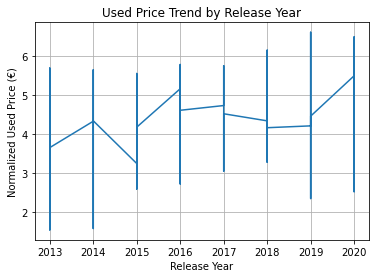

In [14]:
df_sorted = df.sort_values(by='release_year')
plt.plot(df_sorted['release_year'].values, df_sorted['normalized_used_price'].values)
plt.xlabel("Release Year")
plt.ylabel("Normalized Used Price (€)")
plt.title("Used Price Trend by Release Year")
plt.grid(True)
plt.show()


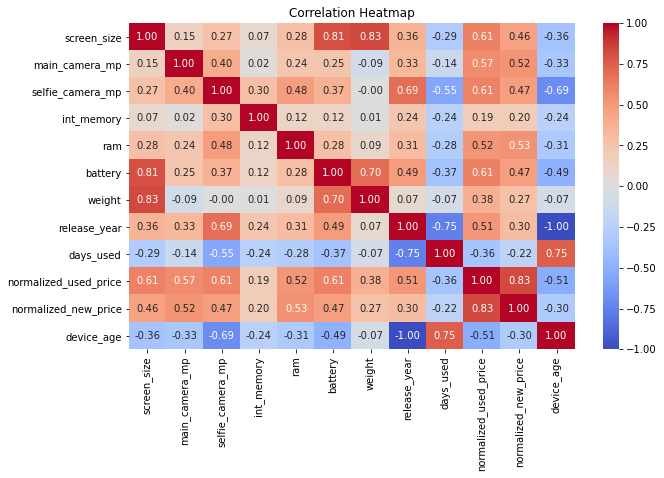

In [15]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Data Preprocessing (Variable encoding)

In [16]:
df.head()

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price,device_age
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100,1
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018,1
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631,1
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961,1
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837,1


### OneHotEncoder Over LabelEncoder

- one-hot encoding is generally preferred over label encoding when dealing with categorical variables that don't have a natural ordinal relationship. Label encoding can introduce misleading ordinal relationships that negatively impact linear regression models


- If Label Encoding is used, the model may think that:
    - os = 2 is twice as "much" as os = 1
  
  This creates a false relationship, leading to bias and poor predictions.

  LabelEncoding is best when There is an ordinal relationship between categories, e.g. [small, medium, large] 

In [17]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
ohe_transform = ohe.fit_transform(df[['brand_name', 'os', '4g', '5g']])
# ohe_transform

In [18]:
df = pd.concat([df, ohe_transform], axis=1).drop(columns=['brand_name', 'os', '4g', '5g'])
df.head()

,screen_size,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,...,brand_name_Xiaomi,brand_name_ZTE,os_Android,os_Others,os_Windows,os_iOS,4g_no,4g_yes,5g_no,5g_yes
0,14.50,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,17.30,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,16.69,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,25.50,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,15.32,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


# Model Building – Linear Regression

In [19]:
X = df.drop(['normalized_used_price'], axis=1)
Y = df['normalized_used_price']

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred

array([3.86637612, 4.9249392 , 4.32027061, 4.04890306, 3.75256739,
       4.25747062, 4.78815779, 4.90379588, 4.08443864, 4.5093527 ,
       4.45595048, 4.50532052, 3.97482888, 4.39830306, 5.14986593,
       3.58065952, 4.41162332, 4.35180565, 4.27576819, 3.40805742,
       4.11172371, 4.38386738, 3.63661238, 3.52372698, 4.50733273,
       4.92445822, 3.4234988 , 4.28762211, 4.29822397, 5.11762285,
       4.41094455, 3.80136379, 5.73131624, 3.95561882, 3.52699022,
       5.2075368 , 3.69889831, 4.7799631 , 4.50488008, 5.6609145 ,
       5.07382831, 5.32369783, 4.43831133, 4.5084314 , 5.12521076,
       4.34355247, 4.68500156, 4.40026611, 3.96010004, 3.48475562,
       5.47184619, 4.97098499, 4.65006242, 3.95512436, 4.3833788 ,
       4.31284633, 4.48176341, 4.6276467 , 4.98497086, 4.63657313,
       4.09196313, 4.83472146, 4.1702013 , 4.24327508, 4.43767141,
       4.21586433, 3.69019834, 3.83734229, 4.36656874, 4.55223595,
       3.57170897, 4.75355714, 4.7855401 , 3.39484518, 3.56404

In [22]:
y_test

511     3.974246
51      5.001191
1171    4.562054
2282    4.176232
557     3.156149
          ...   
2248    4.309322
611     4.378144
3088    4.411828
3170    3.764451
1703    4.524285
Name: normalized_used_price, Length: 691, dtype: float64

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y_test, y_pred)  

mse = mean_squared_error(y_test, y_pred)

print(r2)
print(mse)

0.8356023770790357
0.0533500683429282


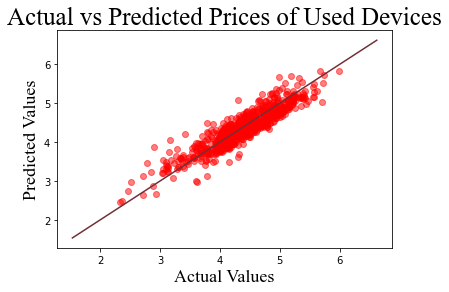

In [24]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5, color='red')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='#722F37')
plt.title('Actual vs Predicted Prices of Used Devices', fontname='Times New Roman', fontsize=25)
plt.xlabel("Actual Values", fontname='Times New Roman', fontsize=18)
plt.ylabel("Predicted Values", fontname='Times New Roman', fontsize=18)
plt.show()

## - Identification of factors that significantly influence the predicted prices.

In [25]:
coeffs = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
coeffs[:10]

normalized_new_price     0.423452
brand_name_Infinix       0.098321
brand_name_Microsoft     0.089044
brand_name_Xiaomi        0.079432
brand_name_Nokia         0.075672
brand_name_Realme        0.073343
os_Android               0.047104
brand_name_OnePlus       0.045240
brand_name_BlackBerry    0.038124
brand_name_Asus          0.034491
dtype: float64

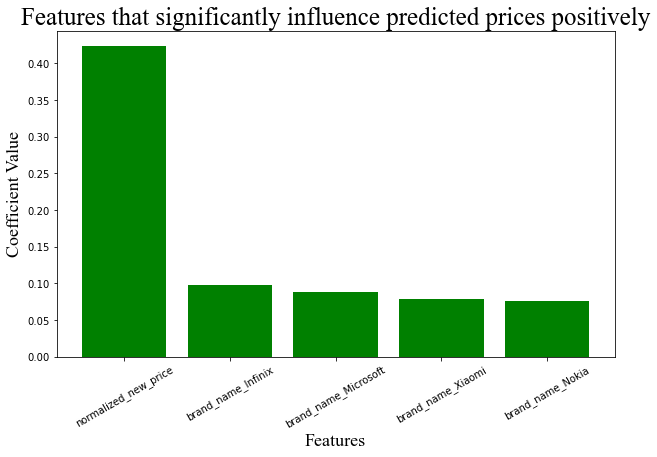

In [26]:
plt.figure(figsize=[10, 6])

cp = coeffs.sort_values(ascending=False)[:5]
plt.bar(cp.index, cp.values, color='green')

plt.title('Features that significantly influence predicted prices positively', fontname='Times New Roman', fontsize=25)
plt.xlabel("Features", fontname='Times New Roman', fontsize=18)
plt.ylabel("Coefficient Value", fontname='Times New Roman', fontsize=18)
plt.xticks(rotation=30)

plt.show()

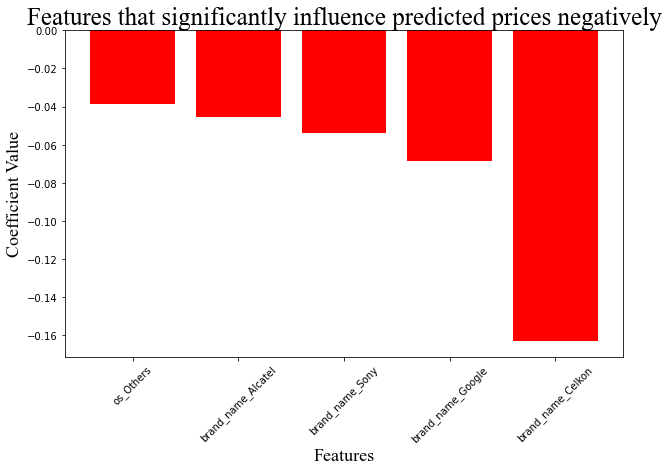

In [27]:
plt.figure(figsize=[10, 6])

cn = coeffs.sort_values(ascending=False)[-5:]
plt.bar(cn.index, cn.values, color='red')

plt.title('Features that significantly influence predicted prices negatively', fontname='Times New Roman', fontsize=25)
plt.xlabel("Features", fontname='Times New Roman', fontsize=18)
plt.ylabel("Coefficient Value", fontname='Times New Roman', fontsize=18)
plt.xticks(rotation=45)

plt.show()